<a href="https://colab.research.google.com/github/Mishra-Nitya/Final-Project/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas scikit-learn tensorflow matplotlib seaborn

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kddcup.data_10_percent_corrected to kddcup.data_10_percent_corrected


Epoch 1/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7130 - val_loss: 0.2600
Epoch 2/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4863 - val_loss: 0.1903
Epoch 3/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3416 - val_loss: 0.1697
Epoch 4/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4319 - val_loss: 0.1598
Epoch 5/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4287 - val_loss: 0.1423
Epoch 6/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4298 - val_loss: 0.1316
Epoch 7/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2806 - val_loss: 0.1214
Epoch 8/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2925 - val_loss: 0.1172
Epoch 9/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1607 - val_loss: 0.1147
Epoch 10/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2089 - val_loss: 0.1119
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  

=== Isolation Forest Evaluation ===
              precision    recall  f1-score   support

  

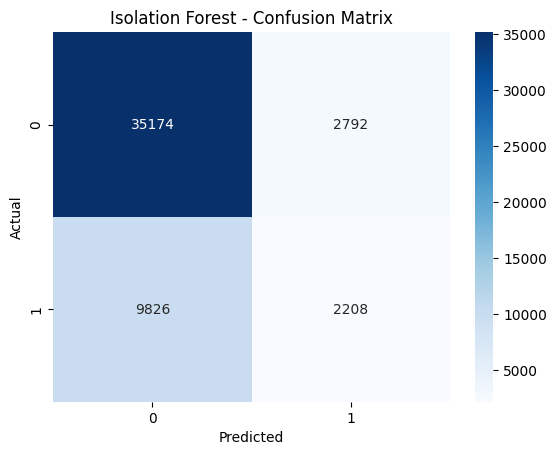


=== Autoencoder Evaluation ===
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     37966
           1       0.86      0.95      0.90     12034

    accuracy                           0.95     50000
   macro avg       0.92      0.95      0.93     50000
weighted avg       0.95      0.95      0.95     50000



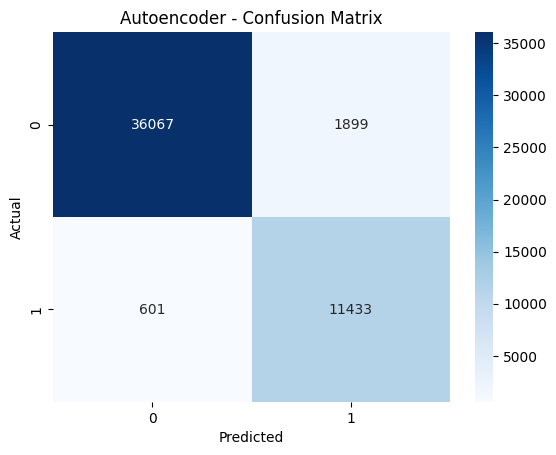


=== Side-by-Side Comparison ===


,Accuracy,Precision,Recall,F1 Score
Model,,,,
Isolation Forest,0.74764,0.441600,0.183480,0.259246
Autoencoder,0.95000,0.857561,0.950058,0.901443


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

# Step 1: Load Dataset
file_path = 'kddcup.data_10_percent_corrected'
column_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
    "urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted",
    "num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
    "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate",
    "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
    "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label"
]
df = pd.read_csv(file_path, names=column_names, nrows=50000)
df['label'] = df['label'].apply(lambda x: 0 if x == 'normal.' else 1)

# Step 2: Select Numerical Features
df_numerical = df.select_dtypes(include=[np.number])
X = df_numerical.drop("label", axis=1)
y = df_numerical["label"]

# Step 3: Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Isolation Forest
iso_model = IsolationForest(contamination=0.1, random_state=42)
y_pred_iso = iso_model.fit_predict(X_scaled)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]

# Step 5: Autoencoder
X_train, X_val = train_test_split(X_scaled[y == 0], test_size=0.2, random_state=42)
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation="relu", activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoded = Dense(8, activation="relu")(encoded)
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(X_val, X_val),
                verbose=1)

# Step 6: Reconstruction Error and Threshold
X_all = X_scaled
reconstructions = autoencoder.predict(X_all)
mse = np.mean(np.power(X_all - reconstructions, 2), axis=1)
threshold = np.percentile(mse[y == 0], 95)  # 95th percentile of normal data
y_pred_ae = [1 if err > threshold else 0 for err in mse]

# Step 7: Evaluation
def evaluate_model(name, y_true, y_pred):
    print(f"\n=== {name} Evaluation ===")
    print(classification_report(y_true, y_pred))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate_model("Isolation Forest", y, y_pred_iso)
evaluate_model("Autoencoder", y, y_pred_ae)

# Step 8: Comparison Summary
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def summary(name, y_true, y_pred):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }

results = [
    summary("Isolation Forest", y, y_pred_iso),
    summary("Autoencoder", y, y_pred_ae)
]

print("\n=== Side-by-Side Comparison ===")
pd.DataFrame(results).set_index("Model")


In [5]:
import joblib
joblib.dump(iso_model, 'isolation_forest_model.pkl')
autoencoder.save('autoencoder_model.h5')
